# **Project 2: Linear Regression**
## Amaan Rahman  & Daniel Mezhiborsky
### ECE 474 
### Professor Keene

## **Abstract**

Applied a bayesian approach to linear regression problems. Implemented and studied the prior, likelihood, and posterior distribution functions to analyze sequential learning. 
$$
\begin{align}
\text{Prior: } &\ p(w|\alpha) = \mathcal{N}(\mathbf{w}|\mathbf{0}, \alpha^{-1}\mathbf{I}) \
\end{align}
$$
$$
\begin{align}
\text{Likelihood: } &\ p(\mathbf{t}|\mathbf{X}, \mathbf{w}, \beta) = \prod_{i=1}^{N} \mathcal{N}(t_n|\mathbf{w}^{\text{T}}\phi (\mathbf{x}_n), \beta^{-1})
\end{align}
$$
$$
\begin{align}
\text{Posterior: } &\ p(w|\mathbf{t}) = \mathcal{N}(\mathbf{w}|\mathbf{m}_N, \mathbf{S}_N)
\end{align}
$$
$$
\begin{align}
\mathbf{m}_N = \beta \mathbf{S}_n \mathbf{\Phi}^{\text{T}}\mathbf{t}
\end{align}
$$
$$
\begin{align}
\mathbf{S}_N^{-1} = \alpha\mathbf{I} + \beta\mathbf{\Phi}^{\text{T}}\mathbf{\Phi}
\end{align}
$$

Given a bayesian linear regression model, the predictive distribution was evaluated to fit the predicted model; the confidence interval of one standard deviation was generated to display how the confidence of the model evolves as the number of samples increases. 

$$
\begin{align}
p(t|\mathbf{t},\alpha,\beta) = \int p(t|\mathbf{w},\beta)p(\mathbf{w}|\mathbf{t},\alpha,\beta)d\mathbf{w}
\end{align}
$$
$$
\begin{align}
\sigma_N^2(\mathbf{x}) = \frac{1}{\beta} + \phi(\mathbf{x})^{\text{T}}\mathbf{S}_n\phi(\mathbf{x})
\end{align}
$$

Finally, evidence approximation has been fully implemented in order to treat the linear regression problem in a complete Bayesian manner by approximating the hyperparameters, $\alpha$ and $\beta$, via maximizing mariginal likelihood; this treatment is known as $\textit{empirical Bayes}$. 
$$
\begin{align}
\gamma = \sum_i \frac{\lambda_i}{\alpha + \lambda_i}
\end{align}
$$
$$
\begin{align}
\alpha = \frac{\lambda}{\mathbf{m}_N^{\text{T}}\mathbf{m}_N}
\end{align}
$$
$$
\begin{align}
\frac{1}{\beta} = \frac{1}{N-\gamma}\sum_{n=1}^{N} \{t_n - \mathbf{m}_N^{\text{T}}\phi (\mathbf{x}_n)\}^2
\end{align}
$$

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

from scipy.stats import multivariate_normal, norm
from tqdm import trange

## **Linear Model**

In [ ]:
class Data(object):
    def __init__(self, fn_type, x_rng, num_samples, epsilon):

        noise = np.random.normal(0, epsilon, size=(num_samples, 1)) # gaussian noise

        self.indicies = np.arange(num_samples)
        self.x = np.linspace(x_rng[0], x_rng[1], num_samples)
        self.x = np.atleast_2d(self.x).T
        if fn_type == 'LINEAR':
            self.t = (A_0 + A_1 * self.x) + noise
        
        elif fn_type == 'SIN':
            self.t = 1 * np.sin(2 * np.pi * self.x) + noise
            self.t_Truth = 1 * np.sin(2 * np.pi * self.x)

    def _getBatch(self, batch_size):
        batch_ind = np.random.choice(self.indicies, size=batch_size)
        return (
            self.x[batch_ind],
            self.t[batch_ind].flatten()
        )


### Bayesian Regression Classes


In [ ]:
class DesignMatrix(object):
    '''
    Design matrix object class
    '''
    def __init__(self, basis_type):
        self.basis_type = basis_type
        self.basis_fn = {
            'LINEAR': self.__identity,
            'GAUSSIAN': self.__gaussian
        }


    def __call__(self, x, **kwargs):
        basis = self.basis_fn[self.basis_type]
        if self.basis_type == 'LINEAR':
            PHI = np.array([basis(x), np.ones(x.shape[0])]).T
        else:
            params = list(kwargs.values())
            assert all(p.shape == params[0].shape for p in params), \
                   "[ERROR]: Specified parameters don't have same shapes"
            PHI = np.concatenate([[np.ones(x.shape[0])] + [basis(x, *p) for p in zip(*params)]], axis=1).T
        return PHI


    def __identity(self, x):
        return x.flatten()


    def __gaussian(self, x, mu, s = 0.1):
        return np.exp(-0.5 * ((x - mu) ** 2) / (s ** 2)).flatten()
        

In [ ]:
# model object class 
class Model(object):
    def __init__(self, basis_type : str,  
                 plt_shape : tuple, 
                 num_samples, 
                 num_basis, 
                 alpha, 
                 beta,
                 model_samples=0):

        self.getDesign = DesignMatrix(basis_type)     # fn for retrieving design matrix
        self.num_samples = num_samples
        self.model_samples = model_samples     
        self.num_basis = num_basis
        self.alpha = alpha
        self.beta = beta
        self.plt_shape = {'r': plt_shape[0], 'c': plt_shape[1], 'n': plt_shape[2]}
        
    
    def _posterior(self, gen_distr = True):
        '''
        Generate posterior distribution given input and target sample data
        '''
        S_inv = (self.alpha * np.eye(self.PHI.shape[1], dtype=np.int) 
                 + self.beta * (self.PHI.T @ self.PHI))
        S = np.linalg.inv(S_inv)
        M = self.beta * (S @ self.PHI.T @ self.t)
        if gen_distr:
            self.w_distr = multivariate_normal(M, S)

        return M, S

    
    def _predict(self, x_train, t_train, x_test, t_test, ax = None, enable_plot = False, **kwargs):
        '''
        Evaluate predictive distribution

        Parameters:
            x_train:        input sample dataset
            t_train:        target sample dataset
            x_test:         input test dataset
            t_test:         target test dataset
            ax:             axes subplot object
            enable_plot:    toggle plots on/off                                        
            kwargs:       positional arguments for rerieving design matrix 
        '''
        self.x = x_train
        self.t = t_train
        
        self.PHI = self.getDesign(x_train, **kwargs)
        M_n, S_n = self._posterior(gen_distr = False)
        PHI_pred = self.getDesign(x_test, **kwargs).T

        mu = M_n.T @ PHI_pred
        covar = 1/self.beta + PHI_pred.T @ S_n @ PHI_pred
        sigma = np.sqrt(np.diag(covar))

        if enable_plot: 
            ax.fill_between(x_test, mu + sigma, mu - sigma, alpha=0.75, color='pink', lw=0)

            ax.plot(x_test, mu, color='red')
            ax.plot(x_test, t_test, color='lime')
            ax.plot(x_train, t_train, 'o', color='blue', mfc='none')

            ax.set_xticks([0, 1])
            ax.set_yticks([-1, 0, 1])
            ax.set_ylim(-1.5, 1.5)
            ax.set_xlim(-0.1, 1.1)
            ax.set_xlabel('x')
            ax.set_ylabel('t')
            ax.text(0.8, 1, f'N = {x_train.shape[0]}')

        return mu, sigma


    def _likelihood(self, x, t):
        '''
        Generate likelihood distribution of the last data point given the 
        design matrix of an arbitrary basis function, as a function of weight space. 

        @param x: sample input data
        @param t: sample target data
        '''
        N = t.shape[0]
        self.t = t
        self.x = x
        self.PHI = self.getDesign(x)
        M = self.w_stack @ self.PHI[N-1].T
        S = 1 / (np.sqrt(BETA))
        self.like_distr = norm(M, S).pdf(t[N-1])
         
    
    def _prior(self, gen_distr = True):
        '''
        Generate prior distribution
        '''
        S = (1 / self.alpha) * np.identity(self.num_basis)
        M = np.zeros(self.num_basis)
        if gen_distr:
            self.w_distr = multivariate_normal(M, S)

    
    def __generateSamples(self):
        '''
        Generate MODEL_SAMPLES number of sample data given the
        newly updated weight distribution
        '''
        W = self.w_distr.rvs(size = self.model_samples).T 
        x = np.linspace(-1, 1, self.num_samples)
        PHI = self.getDesign(x)
        y_hat = PHI @ W # y_hat samples generated

        return (x, y_hat)

    
    def __graph(self, data, **kwargs):
        '''
        Utility graph function

        @param kwargs: positional arguments for plot characteristics
        '''
        (r, c, n) = self.plt_shape.values()
        ax = fig.add_subplot(r, c, n)

        if kwargs['plt_type'] == 'contour':
            (w_0, w_1, z, levels) = data.values()
            ax.contourf(w_0, w_1, z, levels)
            if n != 2:
                ax.plot(A_0, A_1, 'r+')

        elif kwargs['plt_type'] == 'plot':
            (x, y) = data.values()
            ax.plot(x, y, kwargs['color'], zorder=1)
            if self.plt_shape['n'] > 3:
                ax.scatter(self.x, self.t, color='none', edgecolor='b', linewidth=2, zorder=2)

        # subplot attributes
        ax.set_xticks(kwargs['xticks'])
        ax.set_xlabel(kwargs['xlabel'])
        ax.set_yticks(kwargs['yticks'])
        ax.set_ylabel(kwargs['ylabel'])
        ax.set_title(kwargs['title'])


    def _plot(self, fig):
        '''
        Plot likelihood, prior/posterior, and data space
        '''
        n = 1000
        w_0 = np.linspace(-1, 1, n)
        w_1 = np.linspace(-1, 1, n)
        w_0, w_1 = np.meshgrid(w_0, w_1)
        w_0_flat = w_0.flatten()
        w_1_flat = w_1.flatten()
        
        # weight space
        self.w_stack = np.vstack((w_0_flat, w_1_flat)).T

        # plot likelihood
        if self.plt_shape['n'] != 1:
            self.plt_shape['n'] += 1
            title = 'Likelihood'
            z = self.like_distr.reshape(n, n)
            data = {'w_0': w_0, 'w_1': w_1, 'z': z.T, 'levels': self.num_samples}
            self.__graph(data, 
                         plt_type='contour', 
                         xticks=[-1, 0, 1], 
                         yticks=[-1, 0, 1],
                         xlabel=r"$w_0$", 
                         ylabel=r"$w_1$", 
                         title=title)

        # plot prior/posterior
        self.plt_shape['n'] += 1
        title = 'Prior' if self.plt_shape['n'] == 2 else 'Posterior'
        z = self.w_distr.pdf(self.w_stack).reshape(n, n)
        data = {'w_0': w_0, 'w_1': w_1, 'z': z.T, 'levels': 10}
        self.__graph(data,
                     plt_type='contour', 
                     xticks=[-1, 0, 1], 
                     yticks=[-1, 0, 1],
                     xlabel=r"$w_0$", 
                     ylabel=r"$w_1$", 
                     title=title)

        # plot model samples w/ ground truth data points
        x, y_hats = self.__generateSamples()
        self.plt_shape['n'] += 1
        title = 'Data Space'
        data = {'x': x, 'y': y_hats}
        self.__graph(data, 
                     plt_type='plot',
                     xticks=[-1, 0, 1], 
                     yticks=[-1, 0, 1],
                     xlabel='x', 
                     ylabel='y', 
                     color='r', 
                     title=title)


100%|██████████| 4/4 [00:06<00:00,  1.52s/it]


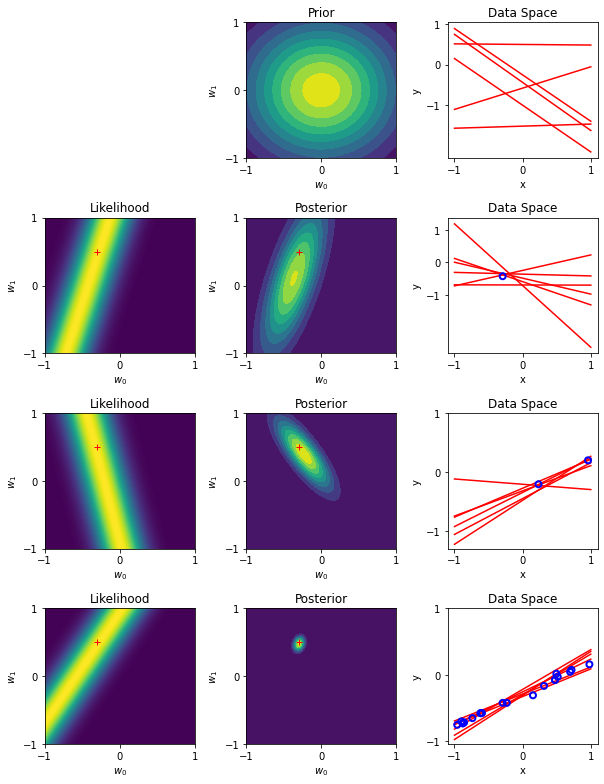

In [ ]:
# === GLOBALS === #
TYPE = 'LINEAR'
NUM_BASIS = 2 # for linear model
NUM_SAMPLES = 100
BATCH_SIZE = [0, 1, 2, 20]
BETA = 25
ALPHA = 2.0
A_0, A_1 = (-0.3, 0.5)

# === DATA GEN === #
noise_std = 1/BETA
data = Data(TYPE, (-1, 1), NUM_SAMPLES, noise_std)

# === Bayesian Linear Regression === #
fig = plt.figure(figsize = (8.5, 11))
model = Model(
    basis_type = TYPE, 
    num_basis = NUM_BASIS, 
    num_samples = NUM_SAMPLES,
    alpha = ALPHA, 
    beta = BETA,
    model_samples = 6, 
    plt_shape = (4, 3, 1)
)

# sequential learning
for i in trange(len(BATCH_SIZE)):
    observations = BATCH_SIZE[i]
    x, t = data._getBatch(observations)
    if observations == 0:
        model._prior()
    else:
        model._likelihood(x, t)
        model._posterior()
    model._plot(fig)

print()
plt.tight_layout()

# **Sinusoidal Predictive Distribution**

100%|██████████| 4/4 [00:00<00:00, 10.63it/s]


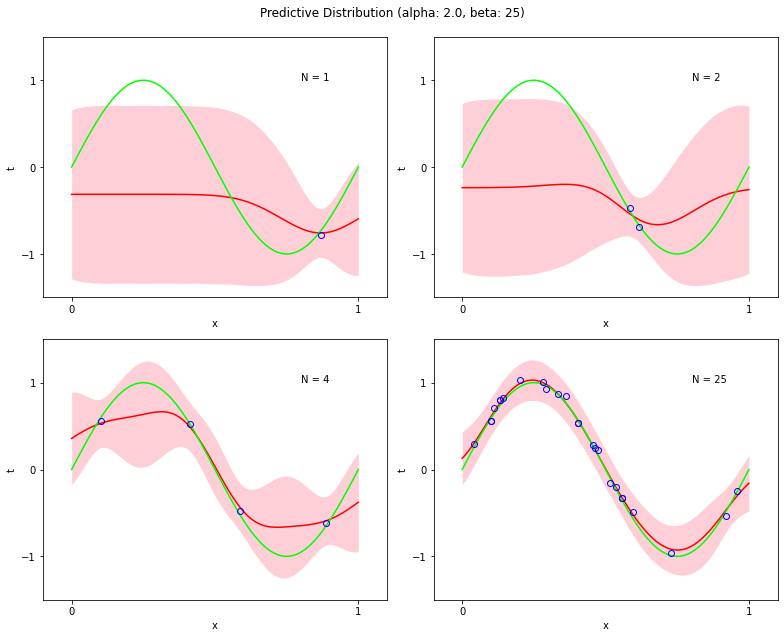

In [ ]:
TYPE = 'SIN'
NUM_BASIS = 9
BATCH_SIZE = [1, 2, 4, 25]
BETA = 25
ALPHA = 2.0
mu_space = np.linspace(0, 1, NUM_BASIS)

# === DATA GEN === #
noise_std = 1/BETA
data = Data(TYPE, (0, 1), NUM_SAMPLES, noise_std)
x_test = np.linspace(0, 1, 100)
t_test = 1 * np.sin(2 * np.pi * x_test)

# === INITIALIZE MODEL === #
fig = plt.figure(figsize = (11, 9))
model = Model(
    basis_type = 'GAUSSIAN', 
    num_basis = NUM_BASIS, 
    num_samples = NUM_SAMPLES,
    alpha = ALPHA, 
    beta = BETA,
    plt_shape = (4, 3, 1)
)
plt_shape = [2, 2, 0]

# === PREDICT === #
PHI_test = DesignMatrix('GAUSSIAN')(x_test, mu=mu_space)
for i in trange(len(BATCH_SIZE)):
    plt_shape[2] += 1
    observations = BATCH_SIZE[i]
    x_train, t_train = data._getBatch(observations)

    ax = fig.add_subplot(*plt_shape)
    with_plot = True
    mu, sigma = model._predict(
        x_train = x_train,
        t_train = t_train, 
        x_test = x_test,
        t_test = t_test,
        ax = ax,
        enable_plot = with_plot,
        mu = mu_space
    )    

    if with_plot:
        plt.suptitle(f'Predictive Distribution (alpha: {model.alpha}, beta: {model.beta})')
        plt.tight_layout(rect=[0, 0, 1, 0.95])

# **Evidence Approximation**

In [ ]:
class EVApproximation(Model):
    '''
    Citation: ref: https://nbviewer.org/github/krasserm/bayesian-machine-learning/blob/dev/bayesian-linear-regression/bayesian_linear_regression.ipynb
    '''
    def __init__(self, x, num_basis, basis_type, **kwargs):
        self.x = x
        self.PHI = DesignMatrix(basis_type)(x, **kwargs)
        self.eigv = np.linalg.eigvalsh(self.PHI.T @ self.PHI)
        self.num_basis = num_basis


    def _maximize_ev(self, t):
        self.t = t
        N, _ = self.PHI.shape
        # gamma calculation
        lambda_set = self.eigv * self.beta
        gamma = np.sum((lambda_set / (lambda_set + self.alpha))).flatten()

        M, S = super()._posterior(gen_distr = False)
        
        # alpha
        new_alpha = gamma / (M.T @ M).flatten()

        # beta
        new_beta_inv = (1 / (N - gamma)) * np.sum((t - self.PHI @ M) ** 2)
        new_beta = 1 / new_beta_inv

        return new_alpha, new_beta

        
    def _fit(self, num_itr, alpha_0, beta_0, t, enable_plot = False):
        alpha_history, beta_history = [], []
        self.alpha, self.beta = alpha_0, beta_0

        for _ in trange(num_itr):
            alpha_history.append(self.alpha)
            beta_history.append(self.beta)
            self.alpha, self.beta = self._maximize_ev(t)
        
        if enable_plot: 
            fig = plt.figure()
            itr = range(num_itr)
            ax = fig.add_subplot(211)
            ax.plot(itr, alpha_history)
            ax.set_xlabel('# Iterations')
            ax.set_title(r"$\alpha\;values$")
            ax = fig.add_subplot(212)
            ax.plot(itr, beta_history)
            ax.set_xlabel('# Iterations')
            ax.set_title(r"$\beta\;values$")
            plt.tight_layout()

        return (self.alpha, self.beta)

    def _eval(self, train, test, ax, enable_plot, **kwargs):
        self.getDesign = DesignMatrix('GAUSSIAN')
        mu, sigma = super()._predict(train[0], train[1], test[0], test[1], ax, enable_plot, **kwargs)
        return mu, sigma

### Convergence plot

100%|██████████| 50/50 [00:00<00:00, 4220.81it/s]
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


Alpha final value: [4.21806302]
Beta final value: [479.83602098]



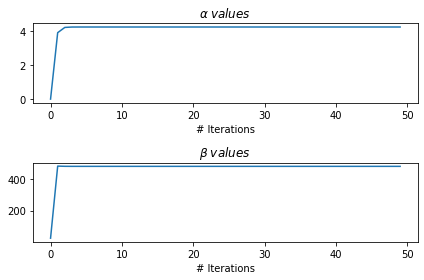

In [ ]:
NUM_ITR = 50
NUM_BASIS = 9
NUM_SAMPLES = 100
alpha, beta = 0.01, 25
mu_space = np.linspace(0.1, 0.99, 9)

noise_std = 1/beta
data = Data('SIN', (0, 1), NUM_SAMPLES, noise_std)
optim = EVApproximation(
    x = data.x,
    num_basis = NUM_BASIS, 
    basis_type = 'GAUSSIAN',
    mu = mu_space
)

latest = optim._fit(
    num_itr = NUM_ITR, 
    alpha_0 = alpha,
    beta_0 = beta,
    t = data.t,
    enable_plot = True
)

print(f'Alpha final value: {latest[0]}')
print(f'Beta final value: {latest[1]}\n')

### Maximized Hyperparameter Evaluation

100%|██████████| 4/4 [00:00<00:00,  8.29it/s]


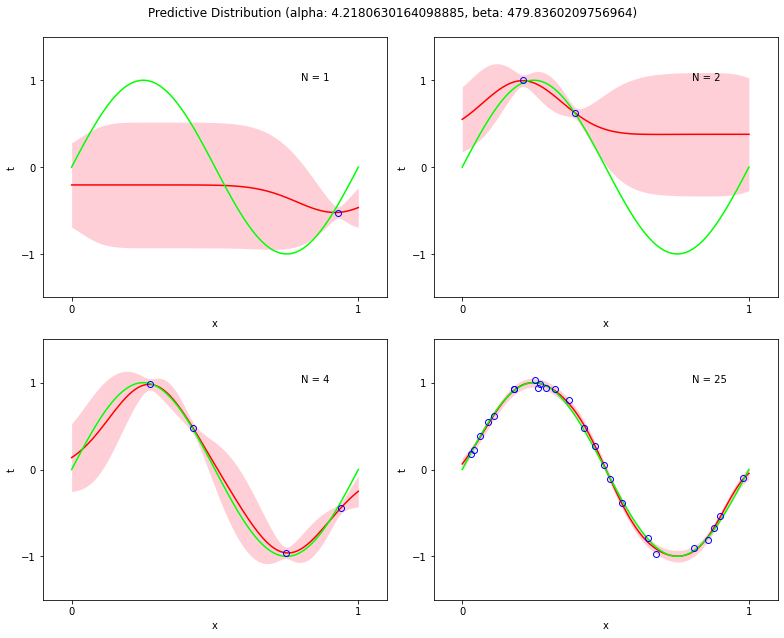

In [ ]:
fig = plt.figure(figsize = (11, 9))
plt_shape = [2, 2, 0]
for i in trange(len(BATCH_SIZE)):
    plt_shape[2] += 1
    observations = BATCH_SIZE[i]
    x_train, t_train = data._getBatch(observations)

    ax = fig.add_subplot(*plt_shape)
    with_plot = True
    mu, sigma = optim._eval(
        train = (x_train, t_train),
        test = (x_test, t_test),
        ax = ax,
        enable_plot = with_plot,
        mu = mu_space
    )

    if with_plot:
        plt.suptitle(f'Predictive Distribution (alpha: {optim.alpha[0]}, beta: {optim.beta[0]})')
        plt.tight_layout(rect=[0, 0, 1, 0.95])